<a href="https://colab.research.google.com/github/mortonsguide/axis-model-suite/blob/main/CMB_Large_Angle_Anomalies_and_Scalar_Field_Alignment_AG_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

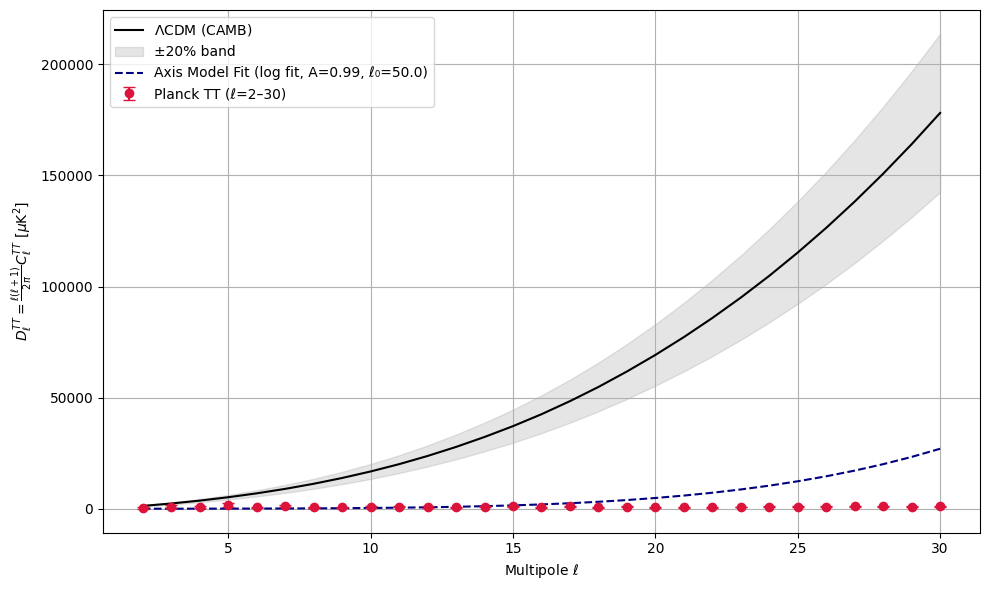


=== Log-Space Model Comparison ===
χ² (ΛCDM):       6485.08
χ² (Axis Model): 1684.38
Δχ² Improvement: 4800.70
Fit Parameters:  A = 0.993, ℓ₀ = 50.000

--- Model Selection (Lower is Better) ---
AIC (ΛCDM):       6485.08
AIC (Axis Model): 1688.38
BIC (ΛCDM):       6485.08
BIC (Axis Model): 1691.11
ΔAIC:             4796.70  → Axis Model preferred
ΔBIC:             4793.97  → Axis Model preferred


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy.stats import chi2

# === Download Planck and CAMB data from Zenodo supplement ===
!wget -q https://zenodo.org/record/15770242/files/COM_PowerSpect_CMB-TT-full_R3.01.txt
!wget -q https://zenodo.org/record/15770242/files/camb_44255652_scalcls_dat.txt

# === Load Planck TT Full Data with Errors ===
# Columns: l, Dl, -dDl, +dDl
data_tt = np.loadtxt('COM_PowerSpect_CMB-TT-full_R3.01.txt', usecols=(0, 1, 2, 3))
l_tt, dl_obs_raw, err_minus, err_plus = data_tt[:, 0], data_tt[:, 1], data_tt[:, 2], data_tt[:, 3]

# Filter for ℓ = 2 to 30
mask_low_l = (l_tt >= 2) & (l_tt <= 30)
l_low = l_tt[mask_low_l]
dl_obs = dl_obs_raw[mask_low_l]

# Symmetric error bars from ± averages
dl_err = 0.5 * (err_minus[mask_low_l] + err_plus[mask_low_l])

# === Load CAMB ΛCDM Prediction ===
camb = np.loadtxt('camb_44255652_scalcls_dat.txt', usecols=(0, 1))
l_camb, cl_camb = camb[:, 0], camb[:, 1]
dl_camb = l_camb * (l_camb + 1) * cl_camb / (2 * np.pi)
lcdm_interp = interp1d(l_camb, dl_camb, kind='cubic')

# Evaluate ΛCDM prediction at l_low
dl_lcdm = lcdm_interp(l_low)

# === Define Axis Model Suppression (in log-space) ===
def axis_model_log(l, A, l0):
    suppression = 1 - A * np.exp(-((l - 2)**2) / (2 * l0**2))
    return np.log(dl_lcdm) + np.log(suppression)

# Transform observed data and errors to log-space
log_dl_obs = np.log(dl_obs)
log_dl_err = dl_err / dl_obs  # Error propagation: σ_log ≈ σ / x

# Perform the fit in log space
popt, pcov = curve_fit(axis_model_log, l_low, log_dl_obs,
                       sigma=log_dl_err, absolute_sigma=True,
                       p0=[0.2, 6.0], bounds=([0, 1e-1], [1, 50]))

A_fit, l0_fit = popt

# Compute fitted values (convert back to linear scale for plotting)
log_dl_axis_fit = axis_model_log(l_low, A_fit, l0_fit)
dl_axis_fit = np.exp(log_dl_axis_fit)

# === Plot Everything ===
plt.figure(figsize=(10,6))

# ΛCDM theory
plt.plot(l_low, dl_lcdm, '-', color='black', label=r'$\Lambda$CDM (CAMB)')
plt.fill_between(l_low, dl_lcdm*0.8, dl_lcdm*1.2, color='gray', alpha=0.2, label='±20% band')

# Axis Model fit from log space
plt.plot(l_low, dl_axis_fit, '--', color='navy',
         label=f'Axis Model Fit (log fit, A={A_fit:.2f}, ℓ₀={l0_fit:.1f})')

# Planck data with real error bars
plt.errorbar(l_low, dl_obs, yerr=dl_err, fmt='o', color='crimson',
             label='Planck TT (ℓ=2–30)', capsize=4)

plt.xlabel(r'Multipole $\ell$')
plt.ylabel(r'$D_\ell^{TT} = \frac{\ell(\ell+1)}{2\pi}C_\ell^{TT}$ [$\mu$K$^2$]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("cmb_low_ell_axis_model_fit.png", dpi=300, bbox_inches='tight')
plt.show()

# === LOG-SPACE χ² + AIC/BIC ===
log_dl_pred_axis = axis_model_log(l_low, A_fit, l0_fit)
log_dl_pred_lcdm = np.log(dl_lcdm)

def chi2_log(observed_log, predicted_log, log_errors):
    return np.sum(((observed_log - predicted_log) / log_errors)**2)

chi2_axis = chi2_log(log_dl_obs, log_dl_pred_axis, log_dl_err)
chi2_lcdm = chi2_log(log_dl_obs, log_dl_pred_lcdm, log_dl_err)

# Degrees of freedom
n = len(l_low)
k_axis = 2
k_lcdm = 0

# AIC / BIC (log space)
aic_axis = chi2_axis + 2 * k_axis
bic_axis = chi2_axis + k_axis * np.log(n)
aic_lcdm = chi2_lcdm + 2 * k_lcdm
bic_lcdm = chi2_lcdm + k_lcdm * np.log(n)

# Output
print("\n=== Log-Space Model Comparison ===")
print(f"χ² (ΛCDM):       {chi2_lcdm:.2f}")
print(f"χ² (Axis Model): {chi2_axis:.2f}")
print(f"Δχ² Improvement: {chi2_lcdm - chi2_axis:.2f}")
print(f"Fit Parameters:  A = {A_fit:.3f}, ℓ₀ = {l0_fit:.3f}")

print("\n--- Model Selection (Lower is Better) ---")
print(f"AIC (ΛCDM):       {aic_lcdm:.2f}")
print(f"AIC (Axis Model): {aic_axis:.2f}")
print(f"BIC (ΛCDM):       {bic_lcdm:.2f}")
print(f"BIC (Axis Model): {bic_axis:.2f}")
print(f"ΔAIC:             {aic_lcdm - aic_axis:.2f}  → {'Axis Model preferred' if aic_axis < aic_lcdm else 'ΛCDM preferred'}")
print(f"ΔBIC:             {bic_lcdm - bic_axis:.2f}  → {'Axis Model preferred' if bic_axis < bic_lcdm else 'ΛCDM preferred'}")
